# Exploratory Data Analysis

This notebook contains the exploratory data analysis for the bank fraud detection dataset. It is split into multiple sections being 

- Initial understanding of the data
- Exploring the features individually (visualization/outliers)
    - Numerical data
    - Categorical data
- Exploring the features in relation to each other (visualization/correlation)
- Identify possible transformations 

### 1. Initial understanding of the data

In [2]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [4]:
# Data collection
total_df = pd.read_csv('./Data/Base.csv')

# Split the DataFrame into training and test sets using stratified sampling to maintain anomaly distribution
train_df, test_df = train_test_split(total_df, test_size=0.2, stratify=total_df['fraud_bool'], random_state=42)

# Validate the size of the data
train_shape = train_df.shape
test_shape = test_df.shape
print(f"The training data has {train_shape[0]} rows and {train_shape[1]} columns.")
print(f"The testing data has {test_shape[0]} rows and {test_shape[1]} columns.")

The training data has 800000 rows and 32 columns.
The testing data has 200000 rows and 32 columns.


We start the EDA by importing data from the Base.csv file and split this up into training and test data to avoid data leakage. The split is done using stratified sampling from the "fraud_bool" feature which preserves output distribution due to most likely unbalanced features. We can see that the data has 32 columns where the training data contains 80000 samples and the test data has 20000. Next we can have a quick look at what the dataframe looks like.

In [7]:
# Shows the first 5 observations of the training data
train_df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
39111,0,0.7,0.229712,-1,63,50,0.024720,50.674001,AA,1305,...,1,1500.0,0,INTERNET,3.580550,linux,0,1,0,0
822700,0,0.2,0.928428,199,24,70,0.014153,15.631407,AA,833,...,0,500.0,0,INTERNET,7.087779,other,1,1,0,6
914415,0,0.1,0.658630,95,2,40,0.045801,-1.410133,AB,237,...,0,200.0,0,INTERNET,0.547804,other,1,1,0,7
581307,0,0.8,0.774858,-1,122,30,0.005569,-0.539938,AB,895,...,1,500.0,0,INTERNET,4.671407,other,1,1,0,4
603136,0,0.9,0.993460,103,9,20,0.010832,-0.501067,AB,4105,...,1,200.0,0,INTERNET,9.293206,linux,0,1,0,4


Above, we can see that the data consists of a target variable called fraud_bool along with many features which give information on whether a certain bank account is fraudulent. The name fraud_bool hints at it being a boolean feature so we can check the different possible outputs in the fraud_bool feature and their distribution by doing the following

In [10]:
# Find the unique values of fraud_bool and prints their distribution
unique_outputs= train_df['fraud_bool'].unique()
print(f"The unique values in the column are: {', '.join(map(str, unique_outputs))}")

# Get the distribution of the fraud_bool
distribution = train_df['fraud_bool'].value_counts(normalize=True)
print("\nDistribution of the output variable:")
for value, proportion in distribution.items():
    print(f"Value {value}: {proportion:.2%}")



The unique values in the column are: 0, 1

Distribution of the output variable:
Value 0: 98.90%
Value 1: 1.10%


Now we see us that our problem is a binary classification problem because we only have two outputs 0 and 1. We also see that our data is highly imbalanced as 98.9% of the data is not fraudulent whereas 1.1% is a fraud. This will need to be taken into account for the preprocessing of the data. Moving on we can calculate the types of all of the features to determine what we are dealing with

In [11]:
# Print the column names, non-null count and datatype
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 39111 to 228494
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        800000 non-null  int64  
 1   income                            800000 non-null  float64
 2   name_email_similarity             800000 non-null  float64
 3   prev_address_months_count         800000 non-null  int64  
 4   current_address_months_count      800000 non-null  int64  
 5   customer_age                      800000 non-null  int64  
 6   days_since_request                800000 non-null  float64
 7   intended_balcon_amount            800000 non-null  float64
 8   payment_type                      800000 non-null  object 
 9   zip_count_4w                      800000 non-null  int64  
 10  velocity_6h                       800000 non-null  float64
 11  velocity_24h                      800000 non-null  fl

Here we get the information that we have no null features or missing features meaning that data imputation won't be necessary for our project. We have numerical features with the type "float64" and categorical features with the type "int64" and "object". We also need to account for that some of our float data also could be categorical so we can find them by counting the number of unique values of the float columns. 

In [6]:
# Number of unique values of the float data
train_df.select_dtypes(include=['float64']).nunique()  

income                            9
name_email_similarity        799289
days_since_request           793121
intended_balcon_amount       796805
velocity_6h                  799150
velocity_24h                 799310
velocity_4w                  798908
proposed_credit_limit            12
session_length_in_minutes    796391
dtype: int64

Which shows us that income and proposed_credit_limit is a categorical feature. Now we can Let's create 2 seperate dataframes for these different feature categories and study them seperately

In [5]:
# Create numerical dataframe
num_df = train_df.select_dtypes(include=['float64']).drop(columns=['income', 'proposed_credit_limit'])

# Create categorical dataframe
cat_df = train_df.select_dtypes(include=['int64', 'object']).copy()
cat_df[['income', 'proposed_credit_limit']] = train_df[['income', 'proposed_credit_limit']]

## 2. Exploring the features individually

### 2.1 Numerical features

We start by analysing the numerical features. The first thing we can check is the statistics of the data such as the mean and standard deviations. 

In [9]:
num_df.describe()

,name_email_similarity,days_since_request,intended_balcon_amount,velocity_6h,velocity_24h,velocity_4w,session_length_in_minutes
count,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.493798,1.024099e+00,8.665099,5664.020229,4770.234656,4856.003621,7.549768
std,0.289099,5.377299e+00,20.232373,3009.677961,1479.503976,919.619696,8.044859
min,0.000001,4.036860e-09,-15.530555,-170.603072,1320.283991,2825.748405,-1.000000
25%,0.225325,7.181675e-03,-1.181143,3434.759967,3593.073983,4268.308917,3.104958
50%,0.492314,1.516505e-02,-0.829849,5316.302685,4750.803340,4913.542421,5.113827
75%,0.755595,2.631458e-02,5.074825,7680.990796,5753.115565,5487.683683,8.866801
max,0.999999,7.845690e+01,112.956928,16715.565404,9506.896596,6994.764201,85.899143


Looking the table above we can see that the features called velocity have a very high mean. When reading the documentation about the dataset we learn that velocity is the average number of applications per hour during the stated time in the feature (velocity_6h is the last 6 hours). One can already speculate that perhaps looking 4 weeks back when averaging per hour won't be a necessary feature since it is over such a long time span that frauds will cancel out in the mix. Another possible issue is that these features will be highly dependant and can probably be combined. Another noticiable thing is that the standard deviation of days_since_request is very large indicating that this feature could be highly imbalanced and skewed. Another interesting aspect is that the minimum value of session_length_in_minutes is -1 which could mean that this value is a placeholder for something else since negative time isn't possible. Further analysis will need to be done on the features individually to determine proper transformations that should be done to the dataset. Finally we see that name_email_similarity has a minimum of 0 and a maximum of 1 which indiciates that this is perhaps a categorical feature too. The first step to analyse the numerical features further will be to look at their distributions together with outliers. 

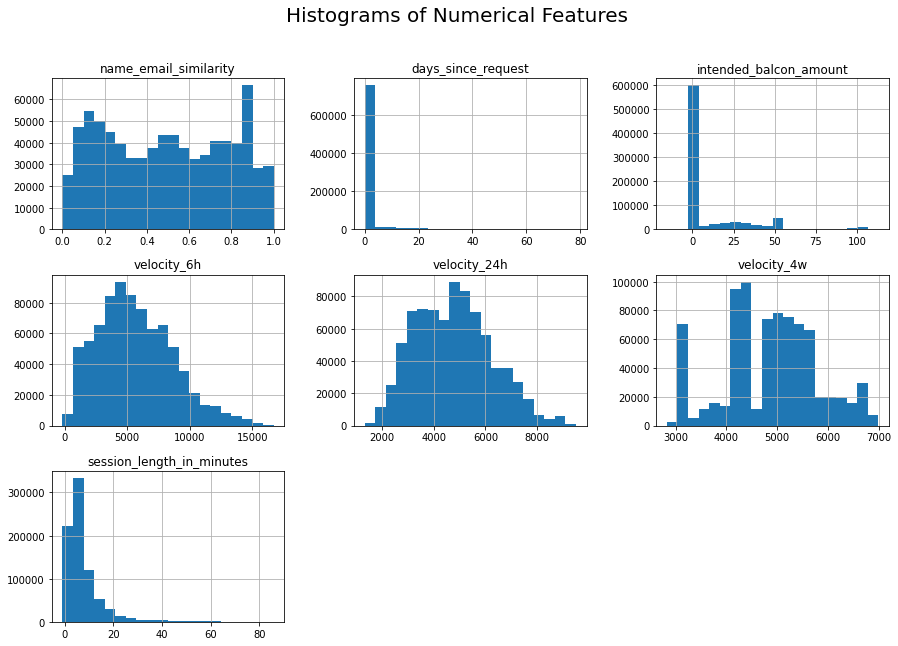

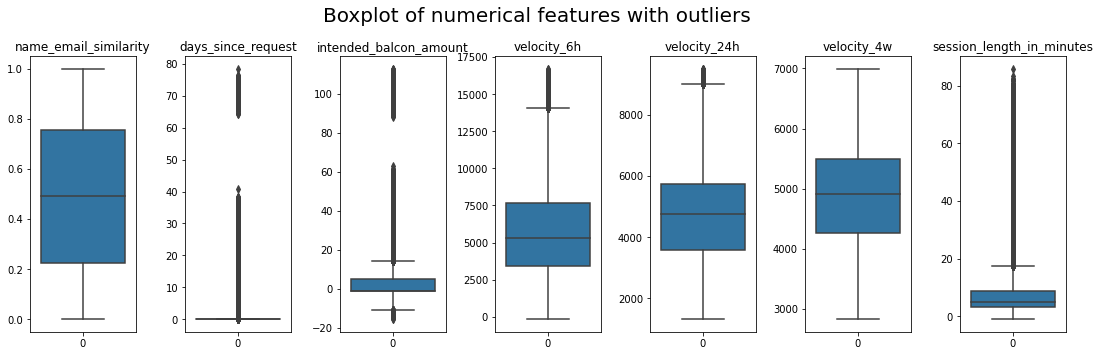

In [37]:
# Histograms of the numerical features
num_df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features', fontsize=20)
plt.show()

# Boxplots for the numerical features
fig, axes = plt.subplots(1, len(num_df.columns), figsize=(15, 5))
axes = axes.flatten()
for i in range(len(num_df.columns)):
    sns.boxplot(data = num_df.iloc[:, i], ax=axes[i])
    axes[i].set_title(num_df.columns[i])

fig.suptitle('Boxplot of numerical features with outliers', fontsize=20)
plt.tight_layout()


What we can see above is that the name_email_similarity appears to follow a pretty uniform distribution with some emails being similar to the reciever and some not being. There is a lower limit of 0 and the upper being 1 which means that this should converted into a categorical feature using binning with a good benchmark perhaps being 5 bins. This feature will be added to cat_df for further analysis. 

The days_since_request feature appears to follow an exponential distribution assuming that there is constant rate of days since the request but with a grouping of outliers around 65-80 days. Since an exponential distribution has the form $f(x)=\lambda e^{-\lambda x}$ a log-transform can be used to make it more uniform and the outliers will be analysed to see if they are correlated with the output. 

The intended_balcon_amount is the initial transfer that the applicant wants to put into the account. Here we have a distinction between putting in nothing and putting in something at all so we could have a binary feature 1 or 0 if the applicant has placed any money. Additionally we can decide to remove the exact amount the applicant places if the exact amount has no correlation with the output at all. Finally we will need to analyse if the grouping of outliers are related to the outliers in days_since_request or are related to the output. 

For the velocity over the last hours they seem to be normally distributed but probably highly correlated. If their correlation is high then they can be combined into one feature. The velocity over 4 weeks almost appears random so we believe this feature should be removed completely. Additionally the outliers seem to be an important part of the data and will be included. 

Finally the session length in minutes also appears to be exponentially distributed so we can use a log-transform however we saw previously that there are values at -1. We should check if this has any correlation with the output and otherwise we will remove these values. Additionally a log-transform will also be benficial to get rid of the exponential part. 


In [12]:
# TODO Calculate the correlations to the output for the numerical data and do more analysis

fraud_bool,0,1
session_length_in_minutes,,
0,1607,16
1,789570,8807


0.9900435594275047
0.9888458274757146


As we can see above our 

In [17]:
numcat_df.describe()

,fraud_bool,prev_address_months_count,current_address_months_count,customer_age,zip_count_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,foreign_request,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.0,800000.000000
mean,0.011029,16.700988,86.614125,33.700075,1572.765860,184.301711,9.504231,131.014702,0.530068,0.417243,0.889406,10.849090,0.222726,0.025313,0.577194,1.018321,0.0,3.288395
std,0.104437,44.017921,88.391093,12.028264,1005.233667,459.482233,5.038498,69.679675,0.499095,0.493104,0.313629,12.120893,0.416076,0.157073,0.494005,0.180909,0.0,2.209459
min,0.000000,-1.000000,-1.000000,10.000000,1.000000,0.000000,0.000000,-170.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,-1.000000,19.000000,20.000000,894.000000,1.000000,6.000000,83.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000
50%,0.000000,-1.000000,52.000000,30.000000,1263.000000,9.000000,9.000000,122.000000,1.000000,0.000000,1.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.0,3.000000
75%,0.000000,12.000000,130.000000,40.000000,1944.000000,25.000000,13.000000,178.000000,1.000000,1.000000,1.000000,25.000000,0.000000,0.000000,1.000000,1.000000,0.0,5.000000
max,1.000000,383.000000,428.000000,90.000000,6700.000000,2385.000000,39.000000,389.000000,1.000000,1.000000,1.000000,32.000000,1.000000,1.000000,1.000000,2.000000,0.0,7.000000


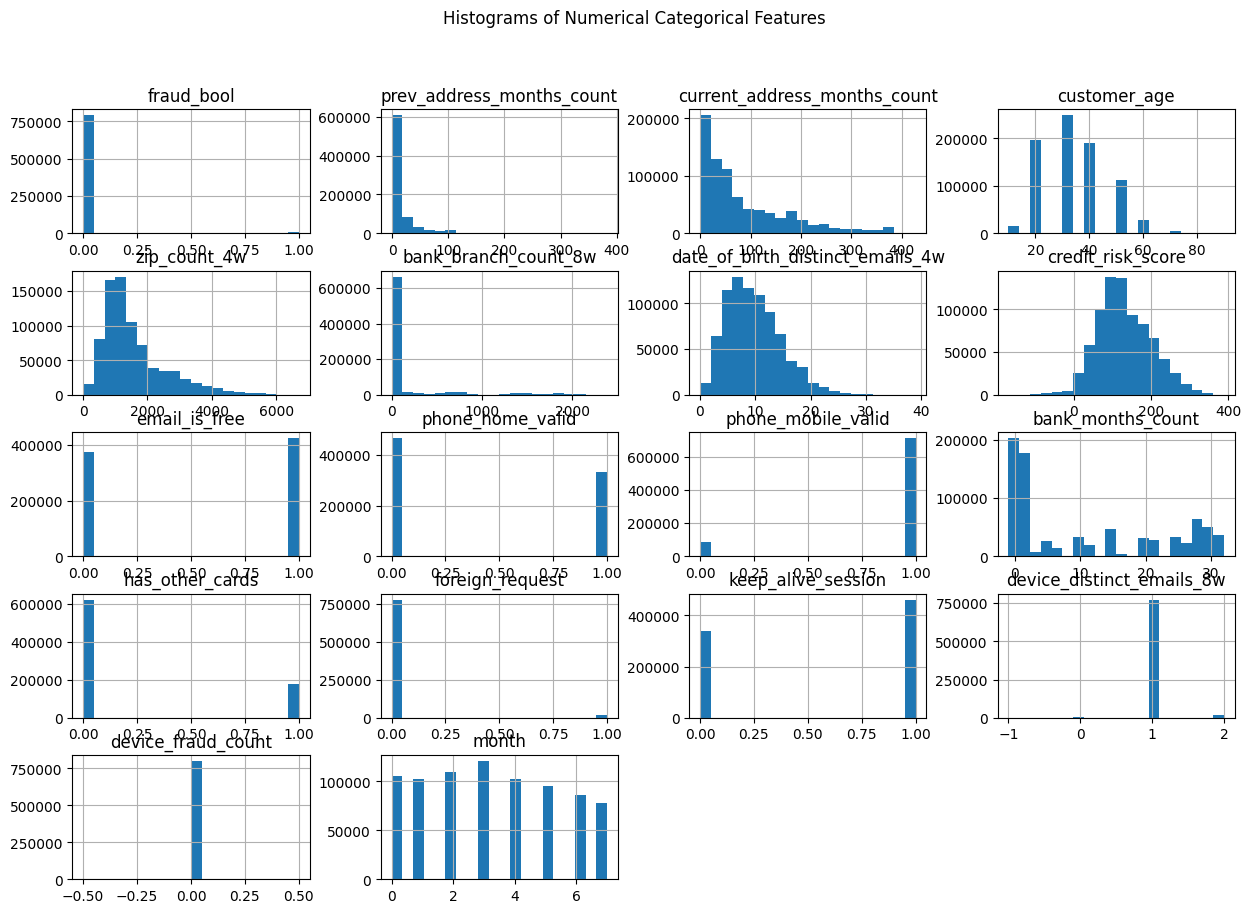

In [18]:
numcat_df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Categorical Features')
plt.show()

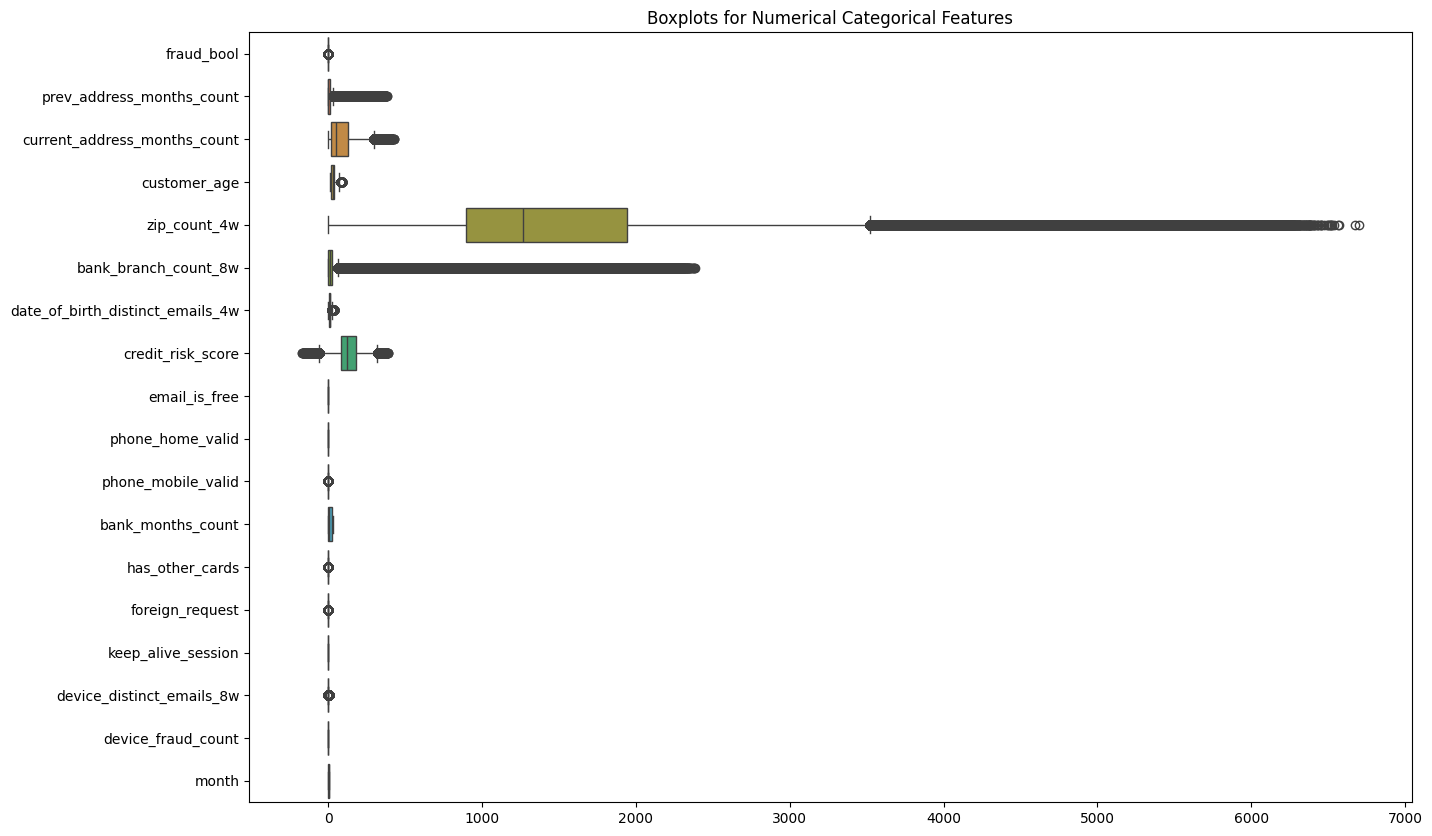

In [19]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=numcat_df, orient="h")
plt.title("Boxplots for Numerical Categorical Features")
plt.show()

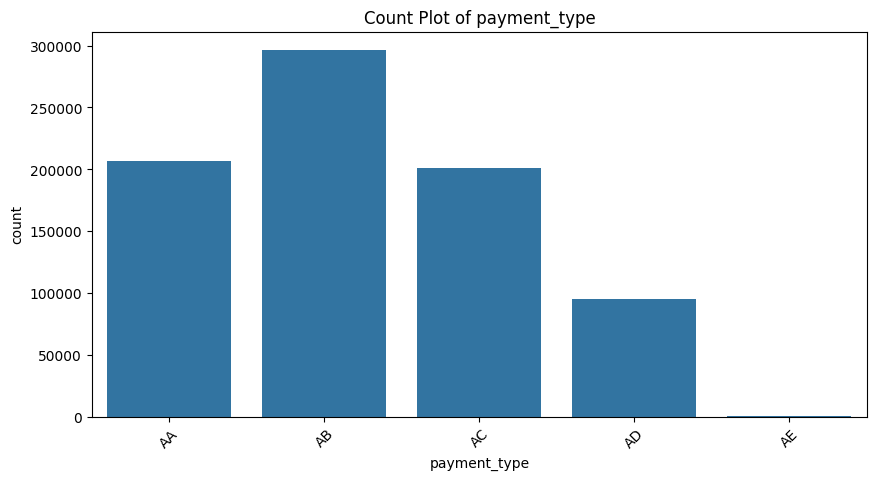

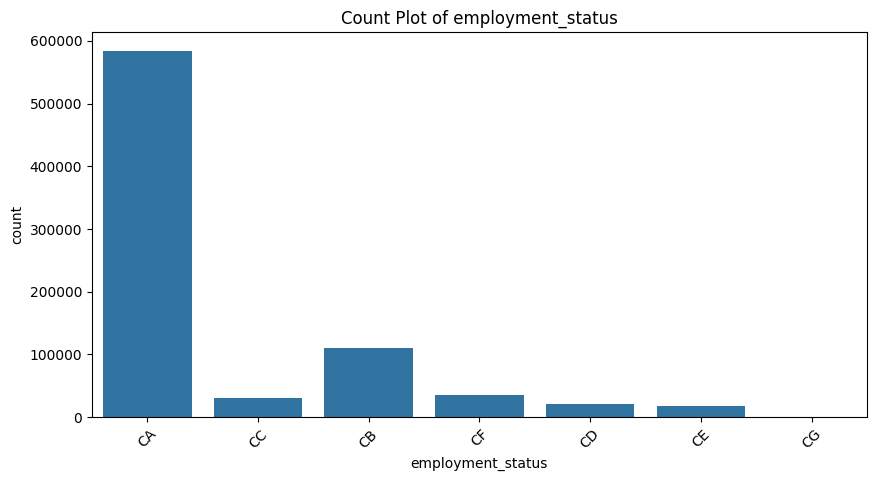

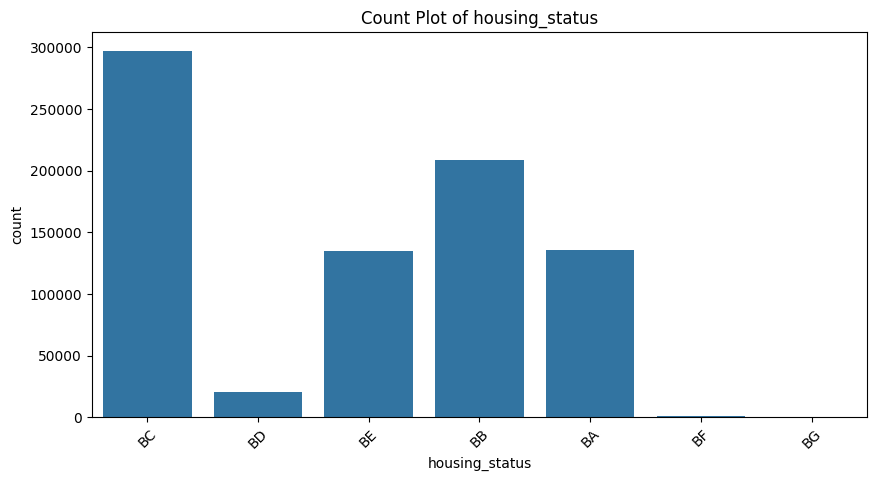

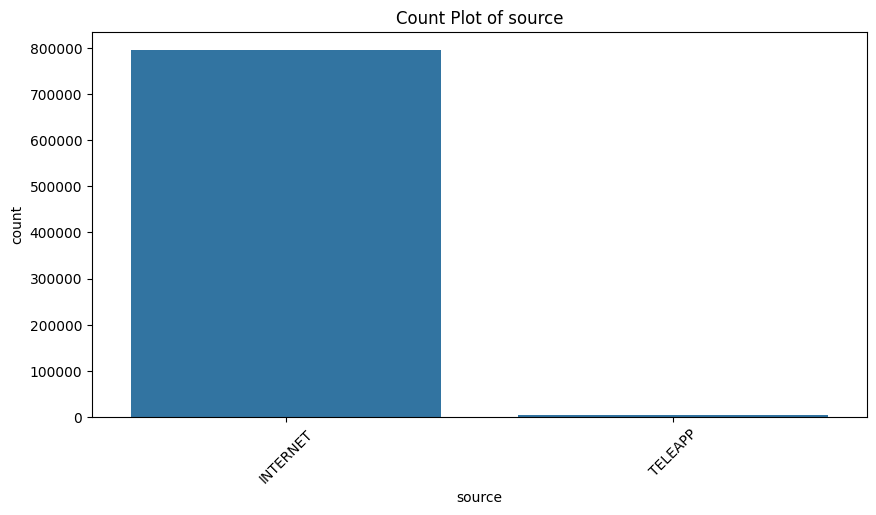

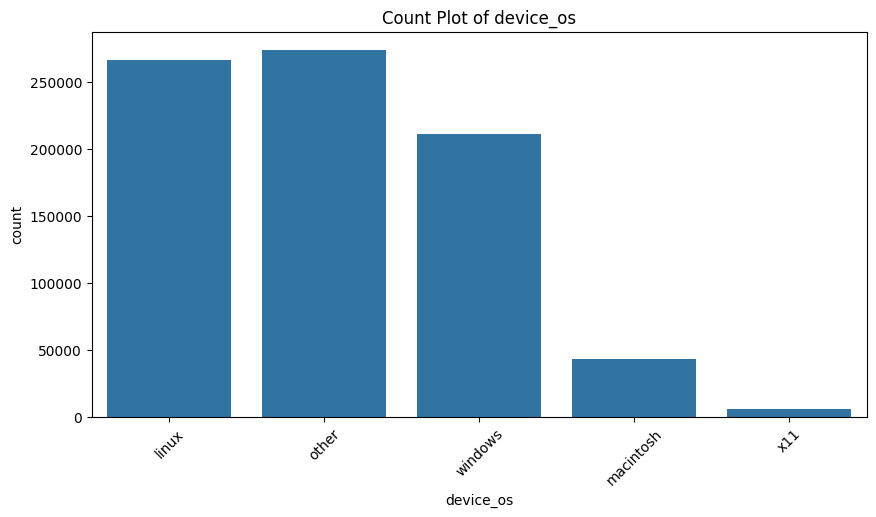

In [20]:
for column in cat_df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=cat_df[column])
    plt.title(f"Count Plot of {column}")
    plt.xticks(rotation=45)
    plt.show()


In [21]:
for column in cat_df.columns:
    unique_vals = cat_df[column].unique()
    print(f"{column} has {len(unique_vals)} unique values: {unique_vals}")

payment_type has 5 unique values: ['AA' 'AB' 'AC' 'AD' 'AE']
employment_status has 7 unique values: ['CA' 'CC' 'CB' 'CF' 'CD' 'CE' 'CG']
housing_status has 7 unique values: ['BC' 'BD' 'BE' 'BB' 'BA' 'BF' 'BG']
source has 2 unique values: ['INTERNET' 'TELEAPP']
device_os has 5 unique values: ['linux' 'other' 'windows' 'macintosh' 'x11']


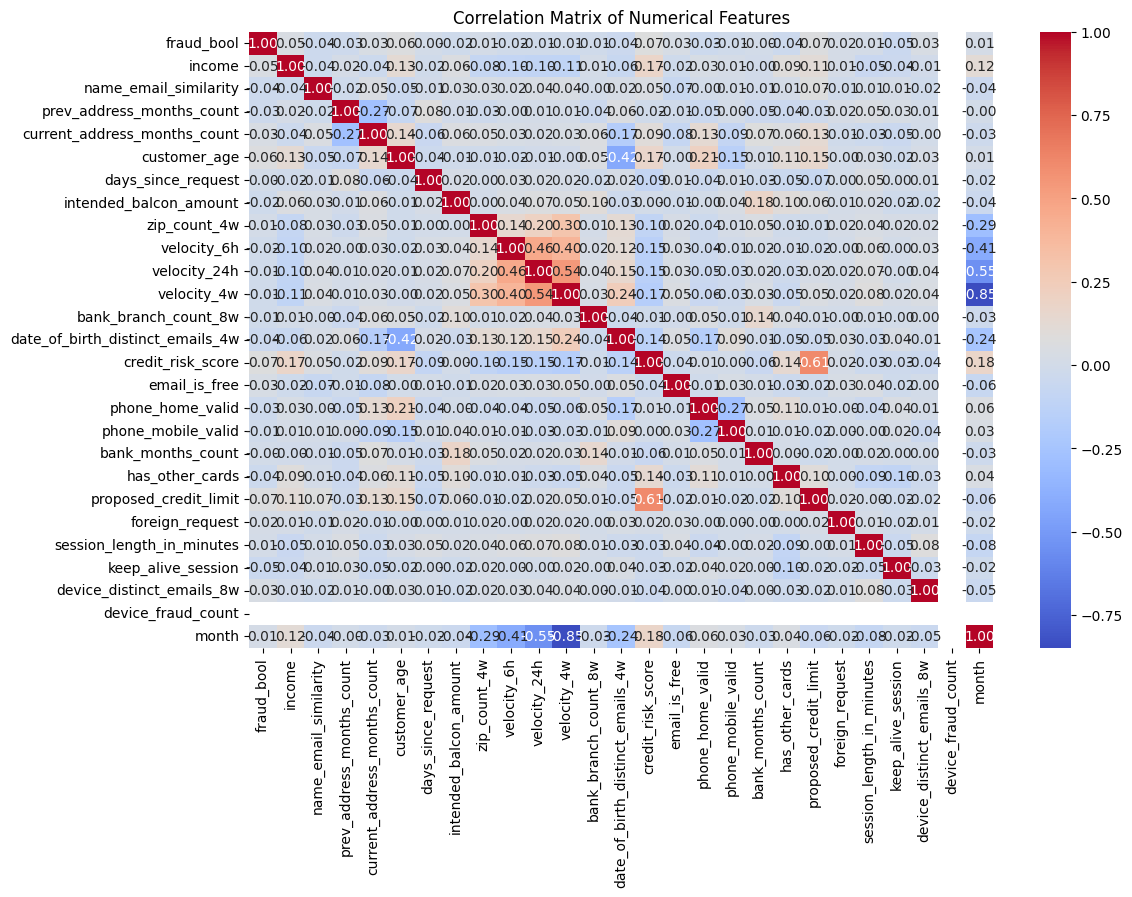

In [24]:
numeric_columns = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_columns.corr()

# Heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [25]:
sns.pairplot(train_df, hue='fraud_bool', diag_kind='kde', palette='Set2')
plt.show()


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001F692D844A0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001F6B4069DA0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [27]:
for column in cat_df.columns:
    cross_tab = pd.crosstab(train_df[column], train_df['fraud_bool'], normalize='index')
    print(f"\nCross-tabulation of {column} with fraud_bool:\n", cross_tab)


Cross-tabulation of payment_type with fraud_bool:
 fraud_bool           0         1
payment_type                    
AA            0.994690  0.005310
AB            0.988712  0.011288
AC            0.983337  0.016663
AD            0.989258  0.010742
AE            0.995671  0.004329

Cross-tabulation of employment_status with fraud_bool:
 fraud_bool                0         1
employment_status                    
CA                 0.987860  0.012140
CB                 0.993034  0.006966
CC                 0.975151  0.024849
CD                 0.995988  0.004012
CE                 0.997680  0.002320
CF                 0.997897  0.002103
CG                 0.986559  0.013441

Cross-tabulation of housing_status with fraud_bool:
 fraud_bool             0         1
housing_status                    
BA              0.962403  0.037597
BB              0.994025  0.005975
BC              0.993941  0.006059
BD              0.991242  0.008758
BE              0.996487  0.003513
BF              0.9

In [33]:
# Find missing values in numerical columns
for column in num_df.columns:
    missing_values = train_df[column] < 0  # Assuming negative values represent missing data
    print(f"{column} has {missing_values.sum()} missing values")
    
    # Replace negative values with NaN
    train_df[column] = train_df[column].replace(-1, np.nan)


income has 0 missing values
name_email_similarity has 0 missing values
days_since_request has 0 missing values
intended_balcon_amount has 593868 missing values
velocity_6h has 0 missing values
velocity_24h has 0 missing values
velocity_4w has 0 missing values
proposed_credit_limit has 0 missing values
session_length_in_minutes has 0 missing values


In [34]:
# One-hot encoding for categorical variables
encoded_train_df = pd.get_dummies(train_df, columns=cat_df.columns, drop_first=True)


In [36]:
# Apply log transformation
for column in ['velocity_6h', 'velocity_24h', 'zip_count_4w']:
    train_df[column] = np.log1p(train_df[column])

In [37]:
train_df.isnull().sum()

fraud_bool                             0
income                                 0
name_email_similarity                  0
prev_address_months_count              0
current_address_months_count           0
customer_age                           0
days_since_request                     0
intended_balcon_amount                 0
payment_type                           0
zip_count_4w                           0
velocity_6h                           36
velocity_24h                           0
velocity_4w                            0
bank_branch_count_8w                   0
date_of_birth_distinct_emails_4w       0
employment_status                      0
credit_risk_score                      0
email_is_free                          0
housing_status                         0
phone_home_valid                       0
phone_mobile_valid                     0
bank_months_count                      0
has_other_cards                        0
proposed_credit_limit                  0
foreign_request 

TODO: Analyse the features one by one and visualise them with histograms and boxplots

fix the bottom 2 cells and maybe remove the sns plot thing that isnt loaded